# Short guide to the extreme-H python implementation.

# Dependencies

In [1]:
# Libraries
import pandas as pd 
import numpy as np
from scipy import stats
from scipy.stats import weibull_min,gamma, gengamma, invgamma,halfnorm,halfgennorm,rayleigh,erlang
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import genextreme
from scipy import integrate
from pynverse import inversefunc
import scipy.stats as stats
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.optimize import root_scalar

/home/tiago/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Auxiliar functions

In [2]:
def H_teta(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def pdf_HG(y, par):
    t1, t2, t3, t4, t5, t6 = par
    H_val = H_teta(t1, t2, t3, t4, t5, t6)
    y = np.array(y)
    pdfh = 1 / H_val * y**t6 * np.exp(-t1 * y - (t2 * y**t3 + t4)**t5)
    return pdfh

def NumIntH(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def NumIntH_distribution(a1, a2, a3, a4, a5, a6, y):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]

def distribution_extreme_H(x, par):
    t1, t2, t3, t4, t5, t6 = par
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)

    if(c_theta==0):
        print('c_theta == 0', t6)
    
    for index, val in enumerate(x):
        if(c_theta==0):
            print('c_theta == 0', t6, NumIntH_distribution(t1, t2, t3, t4, t5, t6, val))
            cdf_vec[index] = 0
        else:
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y
    
# cost/loss function
def ecdf_error(params, data):
    x_empirical, y_empirical = ecdf(data)
    y_theoretical = distribution_extreme_H(x_empirical, params)
    error = np.sum((y_empirical - y_theoretical) ** 2)
    return error

In [3]:
#density function
#y: data set
def dg(y, theta1, theta2, theta3, theta4, theta5, theta6):
    # print('DG theta1=', theta1, type(theta1))
    # print('DG y=', y, type(y))
    c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
    if(c_theta==0):
        print('c_theta == 0', theta6, (y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5) )
        return y*0
    return (1./c_theta)*(y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5)

#log-likelihood function
#x0: data set
def llf(x, t1, t2, t3, t4, t5, t6):

    # print('llf pre-filter x=', x)

    x0=x[dg(x, t1, t2, t3, t4, t5, t6)>0]

    # print('llf pos-filter x0=', x0, 'x<=0: ', x[dg(x, t1, t2, t3, t4, t5, t6)<=0])
    return (sum(np.log(dg(x0, t1, t2, t3, t4, t5, t6))))

def minus_llf(params, data):
    t1, t2, t3, t4, t5, t6 = params
    return -1*llf(data, t1, t2, t3, t4, t5, t6)

global global_parGlobal

def eval_fit_extreme(samples, parameters_tuple, no_print=True):
      
    logLik = llf(samples, parameters_tuple[0], parameters_tuple[1], parameters_tuple[2], parameters_tuple[3], parameters_tuple[4], parameters_tuple[5])

    k = len(parameters_tuple)
    aic = 2*k - 2*(logLik)
    n = np.log(len(samples))
    aicc = aic + 2*k*(k+1)/(n-k-1)

    bic = k*n-2*logLik
    edc = -2*logLik-k*np.log(n)

    if(no_print):
        print('AIC: ', aic, 'AICc:', aicc, 'BIC: ', bic, 'EDC:', edc,'Log-Likelihood', logLik)

    global global_parGlobal
    
    global_parGlobal = parameters_tuple

    # print('global_parGlobal', global_parGlobal)
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    cvm = stats.cramervonmises(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
        print('CVM :', cvm)
    
    return aic, aicc, bic, edc, logLik

def distribution_extreme_H_ks(x):
    #print('global_parGlobal', global_parGlobal)
    t1, t2, t3, t4, t5, t6 = global_parGlobal
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        if val==0:
            cdf_vec[index] = 0
        elif np.isnan(val):
            cdf_vec[index] = 0
        else:
            # print('val =', val)
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec


In [4]:
# Generator and PPF

def _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6):
    
    if isinstance(x, float):      
        
        # print(x)
        
        if x==0:
            return 0
            
        c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
        return (1./c_theta)*NumIntH_distribution(theta1, theta2, theta3, theta4, theta5, theta6, x)
    else:
        return distribution_extreme_H(x, [theta1, theta2, theta3, theta4, theta5, theta6])

def inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,target):
    sol = root_scalar(lambda x, *args: _distribution_extreme_H_priv(x, *args) - target,
                      bracket=(0,1000),# coloquei um limite superior alto, mas da pra estimar a partir dos parametros, eventualmente.
                      args=(theta1, theta2, theta3, theta4, theta5, theta6))
    return sol.root

def extreme_H_rvs2(theta_vec, size=1):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]

    y_values = uniform.rvs(loc=0.0001,scale=0.9998,size=size)

    inv_vals = [inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,y) for y in y_values]

    return np.array(inv_vals)
    
def extreme_H_ppf(samples, theta_vec):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]
    my_F_distribution = (lambda x: _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6))
    
    y_values = samples
    
    return inversefunc(my_F_distribution, y_values=y_values)

## All-in-one

In [5]:
def estimate_extremeH(samples, particular_model_from_table1=4, initial_guess=[], do_metrics=True):

    match particular_model_from_table1:
        case 1:
            print("Frechet")

            base_distribution = stats.invweibull
            
            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]
        
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Frechet: from Table 1
            initial_params = [0, 1/sigma, 1, 0, -shape, -shape-1]
                     
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)

        case 2:
            print("Weibull")
 
            base_distribution = stats.weibull_min

            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (0, 50)]        
            
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Weibull: from Table 1
            initial_params = [0, 1/sigma, 1, 0, shape, shape-1]                     
            
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)
            
        case 3:
            print("Gamma")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]
        
            shape, loc, scale = gamma.fit(samples, floc=0)  
            
            alpha = shape
            beta =  1 / scale  
            
            initial_params = [beta, 0, 1, 0, 1, shape-1]
            print('initial guess ', initial_params)
            
        case _:  # The wildcard '_' acts as the default case
            print("Half-normal")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]
        
            _, scale = halfnorm.fit(samples, floc=0)    
            
            initial_params = [1, 0.5*scale**2, 2, 0, 1, 0]
            print('initial guess ', initial_params)

    data = np.array(samples)

    if len(initial_guess) == 0:
        # LSE ECDF vs CDF: Algorithm 1
        result = minimize(ecdf_error, initial_params, args=(data,), bounds=bounds, method='Nelder-Mead')
        optimal_params = result.x
        print("[Algorithm 1] ECDF optimized parameters:", optimal_params)
    else:
        optimal_params = initial_guess
        print("Skipping Algorithm 1. Got a guess from user input:", optimal_params)    
        
    # MLE: Algorithm 2 (using n-tuple from Algorithm 1)
    if (particular_model_from_table1 == 1) | (particular_model_from_table1 == 2) | (particular_model_from_table1 == 4):
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='Nelder-Mead')
    #elif (particular_model_from_table1 == 4):
    #    result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='SLSQP')
    else:
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='L-BFGS-B')
    
    optimal_params_llf = result.x
    
    print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

    if(do_metrics):
        aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)
        aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)
        return optimal_params_llf, aic, aicc, bic, edc, logLik

    return optimal_params_llf, -1, -1, -1, -1, -1

## CI

In [6]:
def jackknifed_estimate_extremeH(samples, particular_model_from_table1=4, initial_guess=[]):
    
    sample_count=len(samples)

    my_samples = []

    samples = np.array(samples)
    
    idx = np.arange(sample_count)

    # print(idx, range(sample_count))
    
    for i in range(sample_count):
        
        print(i, 'of', sample_count)
        
        jk_sample = samples[idx!=i]
           
        optimal_params_llf, _, _, _, _, _ = estimate_extremeH(jk_sample, particular_model_from_table1, initial_guess, do_metrics=False)
        
        my_samples.append(optimal_params_llf)
        
#     if(display):
#         plot_histogram(my_samples, 'Bootstrap: R', str(runs)+'-run simulation')

    # print(my_samples)

    print('Sample mean', np.mean(my_samples, axis=0), '\nSample median', np.median(my_samples, axis=0))
    print('Q2.5%: ', np.percentile(my_samples, 2.5, axis=0))
    print('Q97.5%: ', np.percentile(my_samples, 97.5, axis=0))

    eval_fit_extreme(samples, np.mean(my_samples, axis=0))
    
    return np.mean(my_samples, axis=0), [np.percentile(my_samples, 2.5, axis=0), np.percentile(my_samples, 97.5, axis=0)], my_samples

## Bootstrap Based Goodness-Of-Fit Test

In [7]:
def eval_ks_cvm(samples, parameters_tuple, no_print=True):
      
    global global_parGlobal
    
    global_parGlobal = parameters_tuple

    # print('global_parGlobal', global_parGlobal)
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    cvm = stats.cramervonmises(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
        print('CVM :', cvm)
    
    return ks.pvalue, ks.statistic, cvm.pvalue, cvm.statistic

In [8]:
def eval_estimated_extremeH(samples, optimal_params, particular_model_from_table1=4, initial_guess=[]):

    data = np.array(samples)

    ks_pvalue, ks_statistic, cvm_pvalue, cvm_statistic = eval_ks_cvm(data, optimal_params)

    M = 150

    n = len(samples)

    idx = np.arange(n)
    samples = np.array(samples)

    p_ks = 0
    p_cvm = 0

    for i in range(M):
        
        print(i, 'of', M, 'params = ',optimal_params)

        if( particular_model_from_table1 != 3 ):
            new_sample = extreme_H_rvs2(optimal_params, n)
            all_zeros = all(x == 0.0 for x in new_sample)
            if all_zeros:
                print('all zeros! resampling...')
                new_sample = extreme_H_rvs2(optimal_params, n)
        else:
            new_sample = samples[idx!=i]
            #new_sample = np.random.choice(samples, n)

        optimal_params_from_sample, _, _, _, _, _ = estimate_extremeH(new_sample, particular_model_from_table1, initial_guess, False)
        ks_pvalue_from_sample, ks_statistic_from_sample, cvm_pvalue_from_sample, cvm_statistic_from_sample = eval_ks_cvm(new_sample, optimal_params_from_sample, False)

        if(ks_statistic_from_sample > ks_statistic):
            p_ks = p_ks + 1
            
        if(cvm_statistic_from_sample > cvm_statistic):
            p_cvm = p_cvm + 1

        print('Partial ks: ', p_ks/(i+1), ' Partial cvm: ', p_cvm/(i+1))

    print('ks: ', p_ks/M)

    print('cvm: ', p_cvm/M)  

    return p_ks/M, p_cvm/M
    

# Examples

In [9]:
def plot_pdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = pdf_HG(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('pdf', fontsize=14)
    plt.show()
        
    return

def plot_cdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = distribution_extreme_H(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('cdf', fontsize=14)
    plt.show()
        
    return

## Plotting PDF and CDF from a parameter tuple

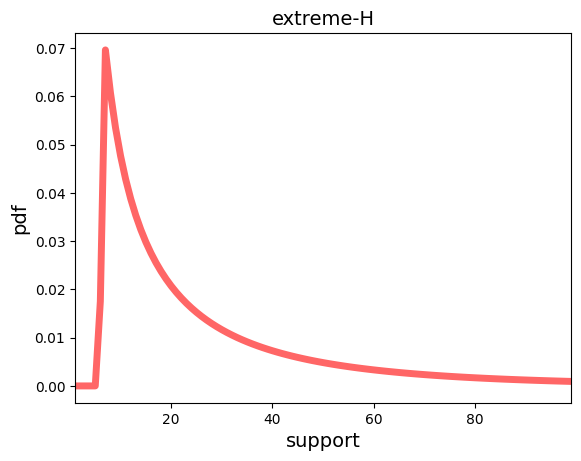

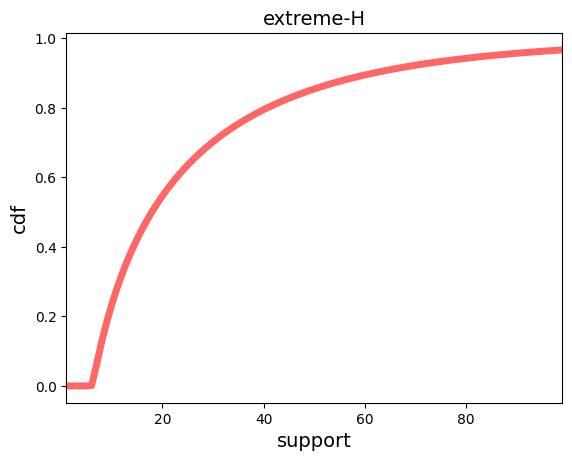

In [10]:
parameter_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]

plot_pdf( parameter_tuple, 'extreme-H', 'support')

plot_cdf( parameter_tuple, 'extreme-H', 'support')

## Taking a parameter tuple to generate samples

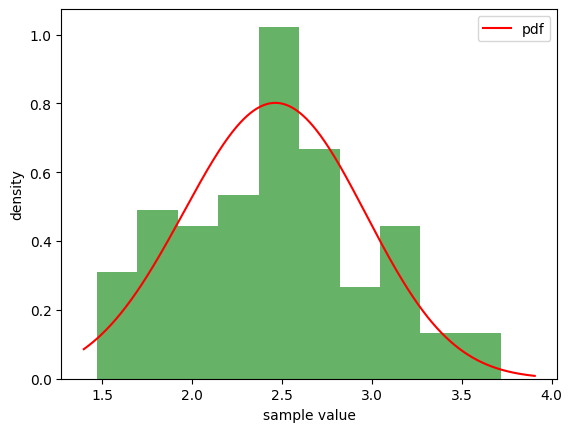

In [11]:
#parameters_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]
parameters_tuple = [2.55584476e-05, 6.43480671e-01, 6.27314530e-01, 1.83895256e-02, 5.40854354e+00, 7.15147852e+00]

sample = extreme_H_rvs2(parameters_tuple, 100)

# print(sample)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = pdf_HG(x, parameters_tuple)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

## Trying Algorithms 1 and 2 from a sample.
### Remark: we need a initial guess to start both algorithms.
#### For Algorithm 1, we can take a particular case (from Table 1) that fits data  

In [12]:
X = sample
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-0.9, 50)]

# we need an initial guess: it is recommended to come from particular cases (Table 1)
initial_params = [0.2, 0.1, 3, 0.1, -9 , -0.9]

# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(X,), bounds=bounds, method='Nelder-Mead')
optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(X),), bounds=bounds, method='Nelder-Mead')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

[Algorithm 1] ECDF optimized parameters: [ 3.17233322  0.02849465  2.96238037  0.19601767 -1.69800881 -0.9       ]
[Algorithm 2] MLE Optimized Parameters: [ 9.99999999  0.02199726  0.46841854  0.11992904 -2.4476331  -0.9       ]


AIC:  166.45169393584408 AICc: 131.37613261264505 BIC:  182.08271505177262 EDC: 145.28861618099666 Log-Likelihood -77.22584696792204
KS : KstestResult(statistic=0.06241924901439211, pvalue=0.8074573580878797, statistic_location=3.03672890527298, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05660959356921774, pvalue=0.8364396692634711)
AIC:  1954.2621976251999 AICc: 1919.1866363020008 BIC:  1969.8932187411285 EDC: 1933.0991198703525 Log-Likelihood -971.1310988125999
KS : KstestResult(statistic=0.5808710189164371, pvalue=1.4663383674884858e-32, statistic_location=3.2493094532230304, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=15.254264482245002, pvalue=2.564920387193581e-09)
AIC:  179.50771533159346 AICc: 144.43215400839443 BIC:  195.138736447522 EDC: 158.34463757674604 Log-Likelihood -83.75385766579673
KS : KstestResult(statistic=0.05919119183239568, pvalue=0.8541172861110162, statistic_location=1.471965446551937, statistic_sign=-1)
CVM : CramerVonMisesResult(sta

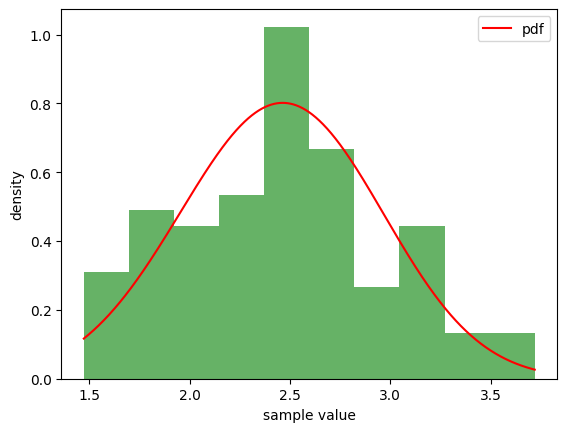

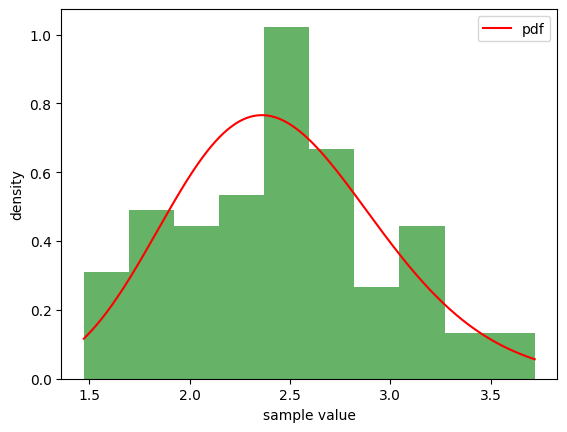

In [13]:
data = sample

generated_params = parameters_tuple

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, generated_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, generated_params)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, optimal_params_llf)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

# Table 3 reproduction

## Frechet

In [14]:
# Piracicaba River dataset
# P. L. Ramos, F. Louzada, E. Ramos, and S. Dey. The fréchet distribution: Estimation and application - an overview. Journal of Statistics and Management Systems, 23(3):549–578, 2020
september_flow = [29.19, 8.49, 7.37, 82.93, 44.18, 13.82, 22.28, 28.06, 6.84, 12.14, 153.78, 17.04, 13.47, 15.43, 30.36, 6.91, 22.12, 35.45, 44.66, 95.81, 6.18, 10.00, 58.39, 24.05, 17.03, 38.65, 47.17, 27.99, 11.84, 9.60, 6.72, 13.74, 14.60, 9.65, 10.39, 60.14, 15.51, 14.69, 16.44]


# Frechet
base_distribution = stats.invweibull

X = september_flow
print('X &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(X, 1)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

X & 6.18  &  11.115  &  16.44  &  28.284871794871798  &  32.905  &  153.78  &  39
Frechet
shape = 1.5644948551004678  scale= 13.76067644260458
initial guess  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 1] ECDF optimized parameters: [ 1.30923457e-02  3.63820093e-01  5.16540683e-01  6.02528066e-04
 -5.08883272e+00 -1.44633923e+00]
[Algorithm 2] MLE Optimized Parameters: [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
AIC:  333.69480197665627 AICc: 308.51825408613166 BIC:  343.67617185343414 EDC: 313.9041871671185 Log-Likelihood -160.84740098832813
KS : KstestResult(statistic=0.07841473668358723, pvalue=0.9548579573017629, statistic_location=27.99, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.03502502024324822, pvalue=0.9587609518455297)
AIC:  328.89213306035896 AICc: 303.71558516983436 BIC:  338.87350293713683 EDC: 309.1015182508212 Log-Likelihood -158.44606653017948
KS : KstestResult(

## p-values: ks and cvm

In [19]:
ks, cvm = eval_estimated_extremeH(X, optimal_params_llf, 1, [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.028689613424730736, pvalue=0.9815131307693734)
0 of 150 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.3840864659162073  scale= 14.680886164641112
initial guess  [0, 0.06811577916927782, 1, 0, -1.3840864659162073, -2.3840864659162073]
Skipping Algorithm 1. Got a guess from user input: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 2] MLE Optimized Parameters: [ 1.98723967e-02  2.89915083e-04  4.45495551e+00  1.50389148e-02
 -1.00000000e+01 -8.12957060e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
Frechet
shape = 1.7685944504505913  scale= 12.029591366092777
initial guess  [0, 0.08312834323023234, 1, 0, -

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(X, 1,  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676])

## Weibull

In [20]:
# The data represent the strength data measured in GPA, for single carbon fibers. Single fibers were tested under tension at gauge length of 20 mm. 69 samples
# R. Valiollahi, A. Asgharzadeh, and M. Z. Raqab. Estimation of P (Y < X) for Weibull distribution under progressive Type-II censoring. Communications in Statistics-Theory and Methods, 42(24):4476–4498, 2013.
Y_carbon_fiber = [1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006,2.021,2.027,2.055, 2.063,2.098,2.140,2.179,2.224,2.240,2.253,2.270,2.272,2.274,2.301,2.301,2.359,2.382,2.382,2.426, 2.434,2.435,2.478,2.490,2.511,2.514,2.535,2.554,2.566,2.570,2.586,2.629,2.633,2.642,2.648,2.684, 2.697,2.726,2.770,2.773,2.800,2.809,2.818,2.821,2.848,2.880,2.954,3.012,3.067,3.084,3.090,3.096, 3.128,3.233,3.433,3.585,3.585]

base_distribution = stats.weibull_min

Y = Y_carbon_fiber

print('Y &', min(Y),' & ', np.percentile(Y,25), ' & ', np.median(Y), ' & ', np.mean(Y), ' & ', np.percentile(Y,75), ' & ', max(Y), ' & ', len(Y))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Y, 2)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

Y & 1.312  &  2.098  &  2.478  &  2.4513333333333334  &  2.773  &  3.585  &  69
Weibull
shape = 5.504860090269867  scale= 2.650855606967049
initial guess  [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 1] ECDF optimized parameters: [3.48481435e-04 5.24727602e-01 7.77338095e-01 2.20756525e-03
 5.51341387e+00 6.10516196e+00]
[Algorithm 2] MLE Optimized Parameters: [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
AIC:  111.1922702651877 AICc: 80.82233731599119 BIC:  124.59690929277126 EDC: 90.53323630318033 Log-Likelihood -49.59613513259385
KS : KstestResult(statistic=0.056129327685893515, pvalue=0.9730632666899052, statistic_location=2.821, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03440612851134288, pvalue=0.9605744039481499)
AIC:  109.74562582610436 AICc: 79.37569287690785 BIC:  123.15026485368791 EDC: 89.08659186409699 Log-Likelihood -48.87281291305218
KS : KstestResult(statistic=0.040467313202

## p-values: ks and cvm

In [21]:
ks, cvm = eval_estimated_extremeH(Y, optimal_params_llf, 2, [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867])

KS : KstestResult(statistic=0.04046731320212715, pvalue=0.9996329483052138, statistic_location=2.821, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.015907051197312904, pvalue=0.9994622103038744)
0 of 150 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.698950127478199  scale= 2.69398504021178
initial guess  [0, 0.37119730996033584, 1, 0, 5.698950127478199, 4.698950127478199]
Skipping Algorithm 1. Got a guess from user input: [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 2] MLE Optimized Parameters: [3.03031608e-06 4.76058805e-01 1.20443889e+00 1.62766094e-06
 2.60601207e+00 8.01248768e+00]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
Weibull
shape = 5.645372592101867  scale= 2.673170502906834
initial guess  [0, 0.3740876232595674, 1, 0, 5.645372592101867, 4.645372592101

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(Y, 2,   [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867])

## Gama

In [22]:
# J. F. Lawless. Statistical models and methods for lifetime data. John Wiley & Sons, 2011.
# W. B. Nelson. Applied Life Data Analysis. John Wiley & Sons, 2005.

Z = [620,470,260,89,388,242, 103,100,39,460,284,1285, 218,393,106,158,152,477, 403,103,69,158,818,947, 399,1274,32,12,134,660, 548,381,203,871,193,531, 317,85,1410,250,41,1101, 32,421,32,343,376,1512, 1792,47,95,76,515,72, 1585,253,6,860,89,1055, 537,101,385,176,11,565, 164,16,1267,352,160,195, 1279,356,751,500,803,560, 151,24,689,1119,1733,2194, 763,555,14,45,776,1, 1747,945,12,1453,14,150, 20,41,35,69,195,89, 1090,1868,294,96,618,44, 142,892,1307,310,230,30, 403,860,23,406,1054,1935, 561,348,130,13,230,250, 317,304,79,1793,536,12, 9,256,201,733,510,660, 122,27,273,1231,182,289, 667,761,1096,43,44,87, 405,998,1409,61,278,407, 113,25,940,28,848,41, 646,575,219,303,304,38, 195,1061,174,377,388,10, 246,323,198,234,39,308, 55,729,813,1216,1618,539, 6,1566,459,946,764,794, 35,181,147,116,141,19, 380,609,546]

print(len(Z))
print(Z)

print('Z &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

# From hyperopt
initial_params_opt = [np.float64(0.0014600180926046908), np.float64(7.168558250732656), np.float64(-6.554152619274005), np.float64(0.0017861406540565223), np.float64(8.57484235581811), np.float64(-0.29244892768030395)]

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3, initial_params_opt)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

# Without an initial guess
optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

201
[620, 470, 260, 89, 388, 242, 103, 100, 39, 460, 284, 1285, 218, 393, 106, 158, 152, 477, 403, 103, 69, 158, 818, 947, 399, 1274, 32, 12, 134, 660, 548, 381, 203, 871, 193, 531, 317, 85, 1410, 250, 41, 1101, 32, 421, 32, 343, 376, 1512, 1792, 47, 95, 76, 515, 72, 1585, 253, 6, 860, 89, 1055, 537, 101, 385, 176, 11, 565, 164, 16, 1267, 352, 160, 195, 1279, 356, 751, 500, 803, 560, 151, 24, 689, 1119, 1733, 2194, 763, 555, 14, 45, 776, 1, 1747, 945, 12, 1453, 14, 150, 20, 41, 35, 69, 195, 89, 1090, 1868, 294, 96, 618, 44, 142, 892, 1307, 310, 230, 30, 403, 860, 23, 406, 1054, 1935, 561, 348, 130, 13, 230, 250, 317, 304, 79, 1793, 536, 12, 9, 256, 201, 733, 510, 660, 122, 27, 273, 1231, 182, 289, 667, 761, 1096, 43, 44, 87, 405, 998, 1409, 61, 278, 407, 113, 25, 940, 28, 848, 41, 646, 575, 219, 303, 304, 38, 195, 1061, 174, 377, 388, 10, 246, 323, 198, 234, 39, 308, 55, 729, 813, 1216, 1618, 539, 6, 1566, 459, 946, 764, 794, 35, 181, 147, 116, 141, 19, 380, 609, 546]
Z & 6.18  &  11.1

## p-values: ks and cvm

In [23]:
ks, cvm = eval_estimated_extremeH(Z, optimal_params_llf, 3, initial_params_opt)
# the inversion procedure used to generate a rv is failing for the Gamma distribution parameters
# in order to compute p_values, we opted to resample the input vector

KS : KstestResult(statistic=0.035531069697490425, pvalue=0.9536290491664662, statistic_location=376, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.05363483680111995, pvalue=0.8544667055262575)
0 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017802507203516537, 0, 1, 0, 1, -0.17598425032443177]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.73674299e-03  7.16890954e+00 -6.55336816e+00  4.52666547e-03
  8.57482195e+00 -1.98930302e-01]
Partial ks:  1.0  Partial cvm:  0.0
1 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017768576667888357, 0, 1, 0, 1, -0.17622213281169385]
Skipping Algorithm 1. Got a guess from user input

/tmp/ipykernel_485031/222251661.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


Partial ks:  1.0  Partial cvm:  0.32142857142857145
84 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.001784123579248061, 0, 1, 0, 1, -0.17546728785050858]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.74063370e-03  7.16891149e+00 -6.55336466e+00  4.53912274e-03
  8.57482247e+00 -1.98352564e-01]
Partial ks:  1.0  Partial cvm:  0.3176470588235294
85 of 150 params =  [ 1.60364398e-03  5.58753345e-08  1.15382476e+00  2.33181583e-04
  7.93549532e-01 -2.56201265e-01]
Gamma
initial guess  [0.0017786765510295437, 0, 1, 0, 1, -0.1761348083286257]
Skipping Algorithm 1. Got a guess from user input: [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(Z, 3, initial_params_opt)

## Another example
### Half-normal

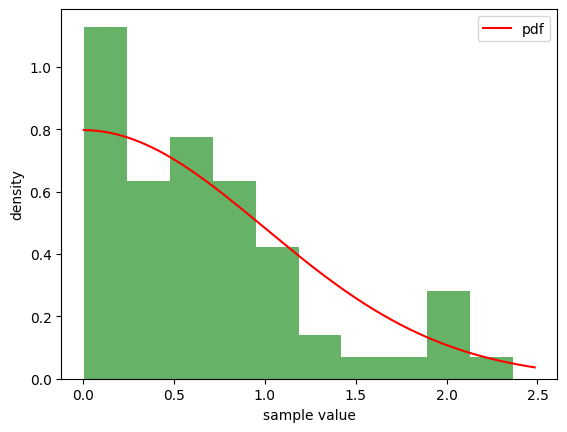

Half-normal
initial guess  [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 1] ECDF optimized parameters: [6.26431158e-04 5.77623154e-01 5.97391343e+00 4.41302749e-06
 2.77201502e-01 4.90953980e-03]
[Algorithm 2] MLE Optimized Parameters: [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
AIC:  93.43077474874727 AICc: 64.52163469453663 BIC:  105.99684212207987 EDC: 72.97313487017355 Log-Likelihood -40.715387374373634
KS : KstestResult(statistic=0.157487587976687, pvalue=0.09123946783954384, statistic_location=0.45810509632477425, statistic_sign=-1)
CVM : CramerVonMisesResult(statistic=0.45703228027529275, pvalue=0.0509528483166809)
AIC:  87.2853438569423 AICc: 58.37620380273167 BIC:  99.8514112302749 EDC: 66.82770397836859 Log-Likelihood -37.64267192847115
KS : KstestResult(statistic=0.0791229772196369, pvalue=0.8181069908441156, statistic_location=0.31215469219720154, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03692444968459228, pv

In [24]:
from scipy.stats import halfnorm

sample = halfnorm.rvs(size=60, loc=0.001)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = halfnorm.pdf(x)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(sample)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

In [25]:
print(sample)

[0.30197491 0.8663517  0.63243762 0.03519632 0.10125061 0.71866119
 0.57672372 2.11414076 0.09161962 0.2162635  1.03416286 1.06902735
 2.36647708 0.08144938 1.35792612 0.77401558 0.83391245 1.90489153
 0.84468819 0.18330454 0.00563777 1.09729381 0.81936663 0.49136359
 0.67836551 2.01363865 0.91589563 0.6461128  0.31215469 0.52614048
 2.08256206 0.4676986  0.16229497 0.60996946 1.86065412 0.19370145
 0.26909494 0.21689483 0.53927397 1.12953483 0.22383464 0.89312108
 0.63283943 0.72408976 0.30376026 0.124055   0.23967612 0.15162491
 1.1485307  0.30816032 0.69408383 1.43575367 0.2923842  0.62939912
 1.08743768 0.46404124 0.4581051  1.28685171 0.22939424 0.16247982]


## p-values: ks and cvm

In [28]:
ks, cvm = eval_estimated_extremeH(sample, optimal_params_llf, 4, [1, 0.4175410142739786, 2, 0, 1, 0])
# [1, 0.8190724130231952, 2, 0, 1, 0]

KS : KstestResult(statistic=0.0791229772196369, pvalue=0.8181069908441156, statistic_location=0.31215469219720154, statistic_sign=1)
CVM : CramerVonMisesResult(statistic=0.03692444968459228, pvalue=0.9496263117853657)
0 of 150 params =  [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
Half-normal
initial guess  [1, 0.3643974423435864, 2, 0, 1, 0]
Skipping Algorithm 1. Got a guess from user input: [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 2] MLE Optimized Parameters: [9.13052310e-03 9.99999990e+00 2.62799912e+00 7.86143806e-01
 4.03025876e-01 6.54805422e-01]
Partial ks:  1.0  Partial cvm:  1.0
1 of 150 params =  [8.82175047e-04 3.66572556e+00 1.00000000e+01 1.31516694e-07
 1.32959242e-01 1.24593761e-01]
Half-normal
initial guess  [1, 0.6558389167818836, 2, 0, 1, 0]
Skipping Algorithm 1. Got a guess from user input: [1, 0.4175410142739786, 2, 0, 1, 0]
[Algorithm 2] MLE Optimized Parameters: [0.36442781 1.15535029 7.97135867 1.29239071 0.15

### CI

In [ ]:
mean_optimal_params_llf, ci_optimal_params_llf, jksamples_optimal_params_llf = jackknifed_estimate_extremeH(sample, 4, [0.03468514, 0.15535166, 9.95952313, 0.01000279, 0.21149506, 0.08174569])